## IBM Quantum Challenge Fall 2021

# challenge 3-solution:
by khadija ech-challaouy

In [2]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

<div class="alert alert-block alert-success">

**Challenge 3a**

Construct a feature map to encode a 5-dimensionally embedded data, using 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default.
    
</div>

Submission format:
```python
ex3a_fmap = ZZFeatureMap(...)

In [ ]:
##############################
# Provide your code here


ex3a_fmap =  ZZFeatureMap(feature_dimension=5, reps=3, entanglement='circular')
ex3a_fmap.decompose().draw('mpl')


##############################

In [ ]:
# Check your answer and submit using the following code
from qc_grader import grade_ex3a
grade_ex3a(ex3a_fmap)

</div>
    
<div class="alert alert-block alert-success">

**Challenge 3b**

Calculate the transition amplitude between $x = (-0.5, -0.4, 0.3, 0, -0.9)$ and $y = (0, -0.7, -0.3, 0, -0.4)$ using the 'ZZFeatureMap' with 3 repetitions, 'circular' entanglement and the rest as default. Use the 'qasm_simulator' with 'shots=8192', 'seed_simulator=1024' and 'seed_transpiler=1024'.
    
</div>

In [ ]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here
kernel = QuantumKernel(feature_map=ZZFeatureMap(feature_dimension=5, reps=3, entanglement='circular'), quantum_instance=Aer.get_backend('qasm_simulator'))
circ = kernel.construct_circuit(x, y)

backend = Aer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(circ)

ex3b_amp = counts['0'*5]/sum(counts.values())

In [ ]:
from qc_grader import grade_ex3b
grade_ex3b(ex3b_amp)

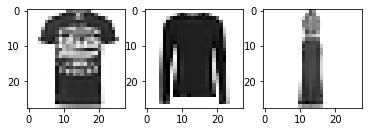

In [3]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [4]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

In [5]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [6]:
pauli_map_0 = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='circular' )
kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = kernel_0.evaluate(x_vec=sample_train)
svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy of discriminating between label 0 and others: 90.0%


In [7]:
matrix_test_0 = kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.47 0.77 0.35 0.21 0.23 0.2  0.51 0.4  0.59 0.45 0.17 0.21 0.21 0.29
 0.27 0.16 0.19 0.55 0.27 0.22]


In [8]:
labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 2 vs Rest: {labels_val_2}')
pauli_map_2 = PauliFeatureMap(feature_dimension=N_DIM, reps=3, paulis = ['X', 'Y', 'ZZ']) # here it better using ZZfeaturemap and change the number of reps,also use circular entanglment
kernel_2 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_2 = SVC(kernel='precomputed', probability=True)

matrix_train_2 = kernel_2.evaluate(x_vec=sample_train)
svc_2.fit(matrix_train_2, labels_train_2)

matrix_val_2 = kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_2 = svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {pauli_score_2*100}%')

matrix_test_2 = kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = svc_2.predict_proba(matrix_test_2)[:, 1]
print(f'Probability of label 2: {np.round(pred_2, 2)}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 2 vs Rest: [0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0]
Accuracy of discriminating between label 2 and others: 90.0%
Probability of label 2: [0.21 0.33 0.3  0.25 0.29 0.37 0.29 0.38 0.31 0.44 0.43 0.38 0.46 0.34
 0.36 0.47 0.3  0.27 0.24 0.61]


In [9]:
labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)
print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 3 vs Rest: {labels_val_3}')
pauli_map_3 = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='linear')
kernel_3 = QuantumKernel(feature_map=pauli_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

svc_3 = SVC(kernel='precomputed', probability=True)

matrix_train_3 = kernel_3.evaluate(x_vec=sample_train)
svc_3.fit(matrix_train_3, labels_train_3)

matrix_val_3 = kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_3 = svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {pauli_score_3*100}%')

matrix_test_3 = kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 = svc_3.predict_proba(matrix_test_3)[:, 1]
print(f'Probability of label 3: {np.round(pred_3, 2)}')


Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 3 vs Rest: [1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1]
Accuracy of discriminating between label 3 and others: 85.0%
Probability of label 3: [0.09 0.09 0.8  0.69 0.45 0.35 0.06 0.27 0.05 0.04 0.93 0.1  0.04 0.31
 0.89 0.06 0.92 0.15 0.68 0.13]


In [9]:
sample_pred = np.load('./resources/ch3_part2_sub.npy')
print(f'Sample prediction: {sample_pred}')

Sample prediction: [0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


In [11]:

pred_test_1=np.where((pred_0>pred_2) & (pred_0>pred_3),0,2)
pred_test=np.where((pred_2>pred_3) & (pred_3<pred_0),pred_test_1,3)
print(pred_test)

[0 0 3 3 3 3 0 0 0 0 3 2 2 3 3 2 3 0 3 2]


In [12]:
# Check your answer and submit using the following code
from qc_grader import grade_ex3c
grade_ex3c(pred_test, sample_train, 
           standard_scaler, pca, min_max_scaler,
           kernel_0, kernel_2, kernel_3,
           svc_0, svc_2, svc_3)

Submitting your answer for 3c. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 1362.
